Used Python libraries and SQL syntax to generate visualisations from https://covid.ourworldindata.org/data/owid-covid-data.csv

**Requirements**:
- Python3
- NumPy
- Pandas
- Pandasql
- Matplotlib
- Seaborn
- Plotly

In [22]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from pandasql import sqldf
df = pd.read_csv("~\owid-covid-data.csv")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.date = pd.to_datetime(df.date,yearfirst=True,format='%Y-%m-%d')
df1 = df[df.date.dt.year.between(2020,2022)]
df2 = df[(df.date.dt.year == 2023) & (df.date.dt.month == 1)]
df = pd.concat([df1,df2]).replace(' 00:00:00.000000','',regex=True)

In [245]:
# cases-death ratio in UK --> lineplot
data2=sqldf('''
select date,total_deaths,total_cases, round(total_deaths/total_cases,5) death_perc
from df
where location like '%United Kingdom%'
''').replace(' 00:00:00.000000','',regex=True)

In [246]:
# cases-population ratio in UK --> lineplot
data3=sqldf('''
select date,total_cases,population, round(total_cases/population*100,5) cases_pop
from df
where location like '%United Kingdom%'
''').replace(' 00:00:00.000000','',regex=True)

In [6]:
# Highest infection rates per country --> barplot
data4=sqldf('''
select location,max(total_cases) max_cases,population, max(round(total_cases/population*100,5)) max_cases_pop
from df
-- where location like '%United Kingdom%'
Where continent is not null 
group by location,population order by max_cases_pop desc -- max(round(total_cases/population*100,5)) desc
''')

In [26]:
# total deaths per continent --> max() b/c total_deaths is cumulative over time t/f get max returns latest total_deaths
data5=sqldf('''
Select continent, max(Total_deaths) as TotalDeathCount
From df
Where continent is not null 
Group by continent
order by TotalDeathCount desc
''')
# 'location' columns contains both countries & continents therefore max() aggregates both countries & continents
# e.g. Asia can be found in both 'location' and 'continent' cols --> therefore use 'where continent is not null' to only
# include country-level data, not continent-level data in aggregatate function

In [181]:
# num and % of people vaxxed in UK FINAL
data6=sqldf('''
With a as (
Select continent, location, date, population, people_vaccinated,total_boosters
From df
where continent is not null and location like  '%United Kingdom%'
)
Select *, ROUND((People_Vaccinated/Population)*100,3) as PercentPeopleVaccinated,
ROUND((total_boosters/Population)*100,3) as PercentPeopleBoosted
From a
where people_vaccinated > 0
''').replace(np.nan,0).replace(' 00:00:00.000000','',regex=True)

In [187]:
# Weekly hospital admissions
data7=sqldf('''
Select location, date, population,weekly_hosp_admissions_per_million
From df
where continent is not null and location like  '%United Kingdom%'
''').replace(np.nan,0).replace(' 00:00:00.000000','',regex=True)

(0.0, 0.32927)

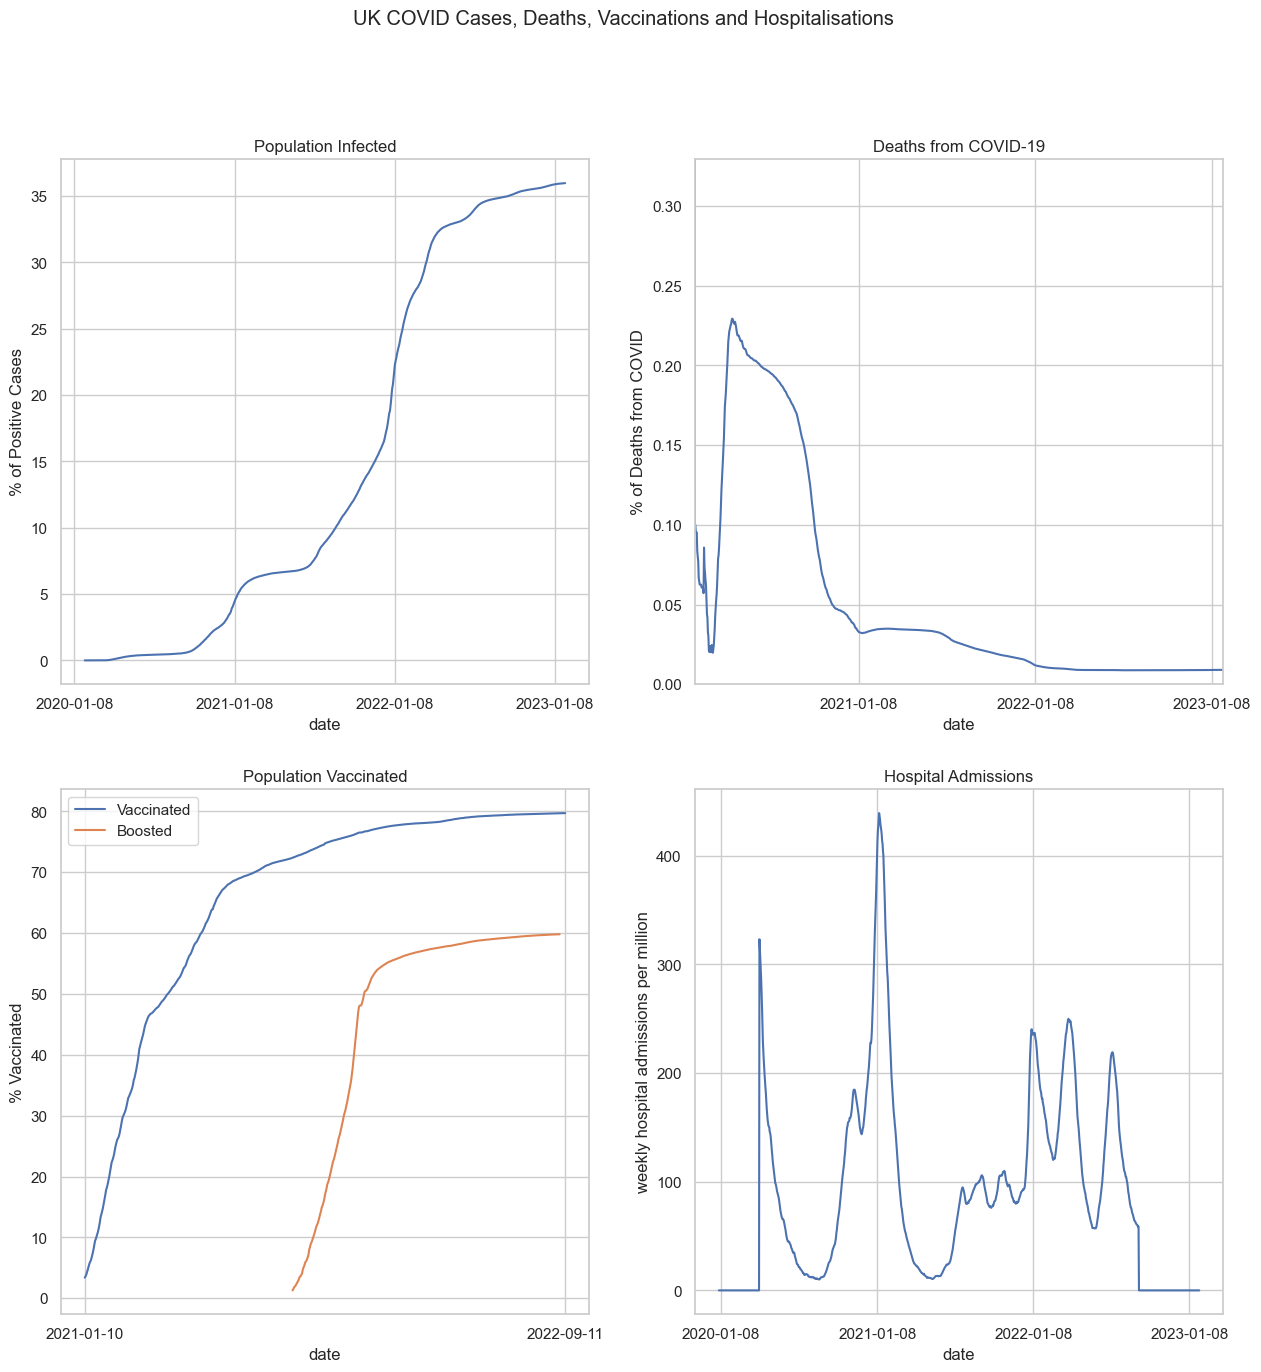

In [319]:
fig,axs = plt.subplots(2,2,figsize=(15,15))
sns.lineplot(data=data3,x='date',y='cases_pop',ax=axs[0,0]) # cases as proportion of population
sns.lineplot(data=data2,x='date',y='death_perc',ax=axs[0,1]) # Death % of total cases 

sns.lineplot(data=data6,x='date',y='PercentPeopleVaccinated',ax=axs[1,0],label='Vaccinated')
sns.lineplot(data=data6[data6.PercentPeopleBoosted > 0],x='date',y='PercentPeopleBoosted',ax=axs[1,0],label='Boosted')
sns.lineplot(data=data7,x='date',y='weekly_hosp_admissions_per_million',ax=axs[1,1])

fig.suptitle('UK COVID Cases, Deaths, Vaccinations and Hospitalisations')
axs[1,0].ticklabel_format(style='plain',axis='y')
axs[0,0].set_xticks(['2020-01-08','2021-01-08','2022-01-08','2023-01-08'])
axs[0,1].set_xticks(['2020-01-08','2021-01-08','2022-01-08','2023-01-08'])
axs[1,0].set_xticks([data6.date[0],data6.date[len(data6)-1]])
axs[1,1].set_xticks(['2020-01-08','2021-01-08','2022-01-08','2023-01-08'])

axs[0,0].set_title('Population Infected')
axs[0,1].set_title('Deaths from COVID-19')
axs[1,0].set_title('Population Vaccinated')
axs[1,1].set_title('Hospital Admissions')
axs[0,0].set_ylabel('% of Positive Cases')
axs[0,1].set_ylabel('% of Deaths from COVID')
axs[1,0].set_ylabel('% Vaccinated')
axs[1,1].set_ylabel('weekly hospital admissions per million')

#axs[0,1].set_ylim(data2[data2.death_perc<1].death_perc.reset_index().death_perc[0],data2.iloc[-1].death_perc)
axs[0,1].set_xlim(data2[data2.death_perc<1].date.reset_index().date[0],data2.iloc[-1].date)
axs[0,1].set_ylim(0,data2[data2.death_perc<1].death_perc.max() + .1)

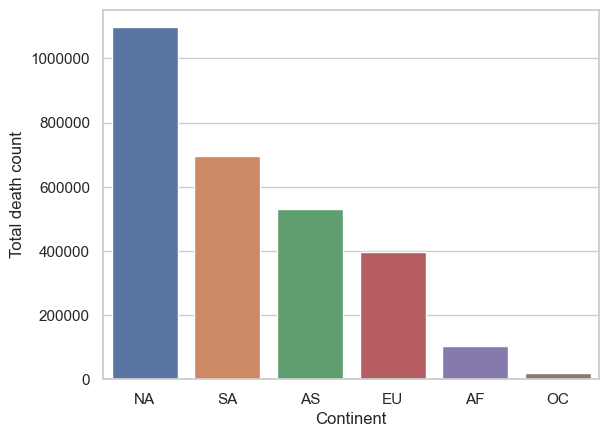

In [305]:
# Total death count per continent
sns.barplot(data=data5\
.replace({'North America':'NA','South America':'SA','Asia':'AS','Africa':'AF','Oceania':'OC','Europe':'EU'})\
.rename(columns={'TotalDeathCount':'Total death count','continent':'Continent'}),\
x='Continent',y='Total death count')
plt.ticklabel_format(style='plain',axis='y')

In [23]:
# total deaths per continent --> top 3 countries per continent 
data5v2=sqldf('''
with a as (select *, rank() over (partition by continent order by max_deaths desc) as row
from (
    Select continent,location, max(Total_deaths) as max_deaths
    From df
    Where continent is not null
    group by 1,2
    order by 1,2
    ))
select continent,location,max_deaths, max_deaths / (select max(max_deaths) from a) as max_deaths_norm
from a where row between 1 and 3
''')

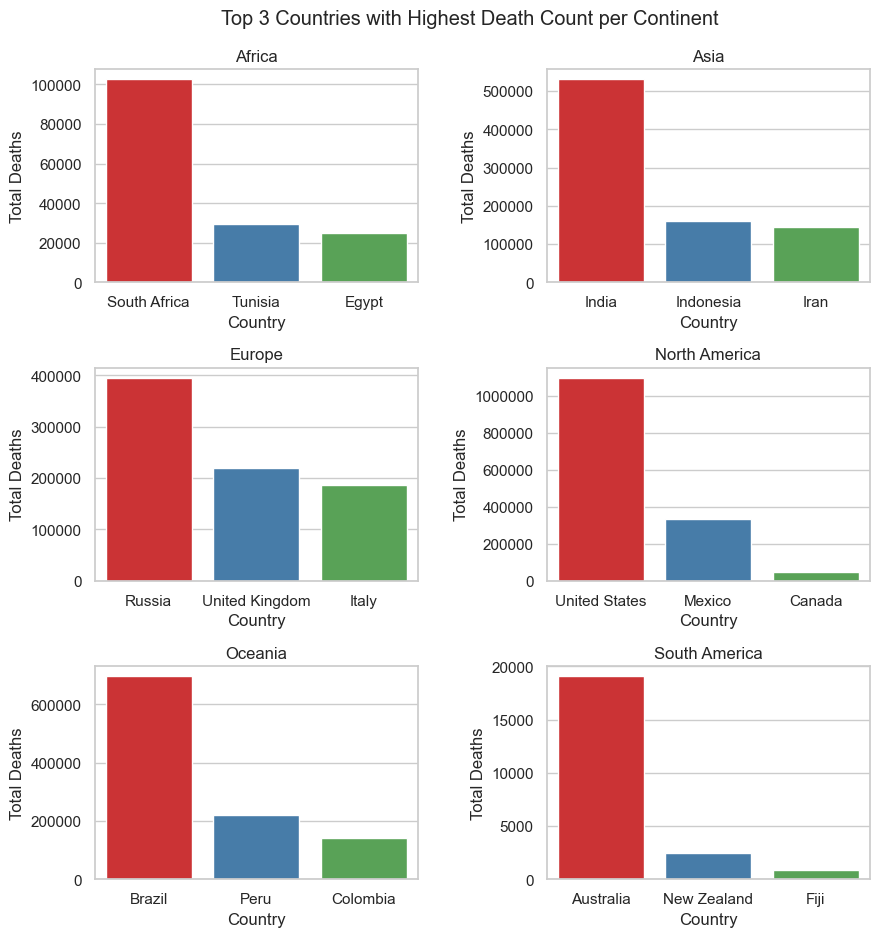

In [307]:
# Top 3 Countries w highest death count per continent
fig,axs = plt.subplots(3,2,figsize=(10,10))
sns.barplot(data=data5v2[data5v2.continent== 'Africa'], x='location', y='max_deaths', palette='Set1',ax=axs[0,0])
sns.barplot(data=data5v2[data5v2.continent== 'Asia'], x='location', y='max_deaths', palette='Set1',ax=axs[0,1])
sns.barplot(data=data5v2[data5v2.continent== 'Europe'], x='location', y='max_deaths', palette='Set1',ax=axs[1,0])
sns.barplot(data=data5v2[data5v2.continent== 'North America'], x='location', y='max_deaths', palette='Set1',ax=axs[1,1])
sns.barplot(data=data5v2[data5v2.continent== 'South America'], x='location', y='max_deaths', palette='Set1',ax=axs[2,0])
sns.barplot(data=data5v2[data5v2.continent == 'Oceania'], x='location', y='max_deaths', palette='Set1',ax=axs[2,1])
axs[1,1].ticklabel_format(style='plain',axis='y')
fig.suptitle('Top 3 Countries with Highest Death Count per Continent')
plt.subplots_adjust(wspace = 0.4,top=.92,hspace=.4)

axes = [ax for ax_lst in axs for ax in ax_lst]
for ax,continent in zip(axes,data5v2.continent.unique()):
    ax.set_title(continent)
    ax.set_ylabel('Total Deaths')
    ax.set_xlabel('Country')

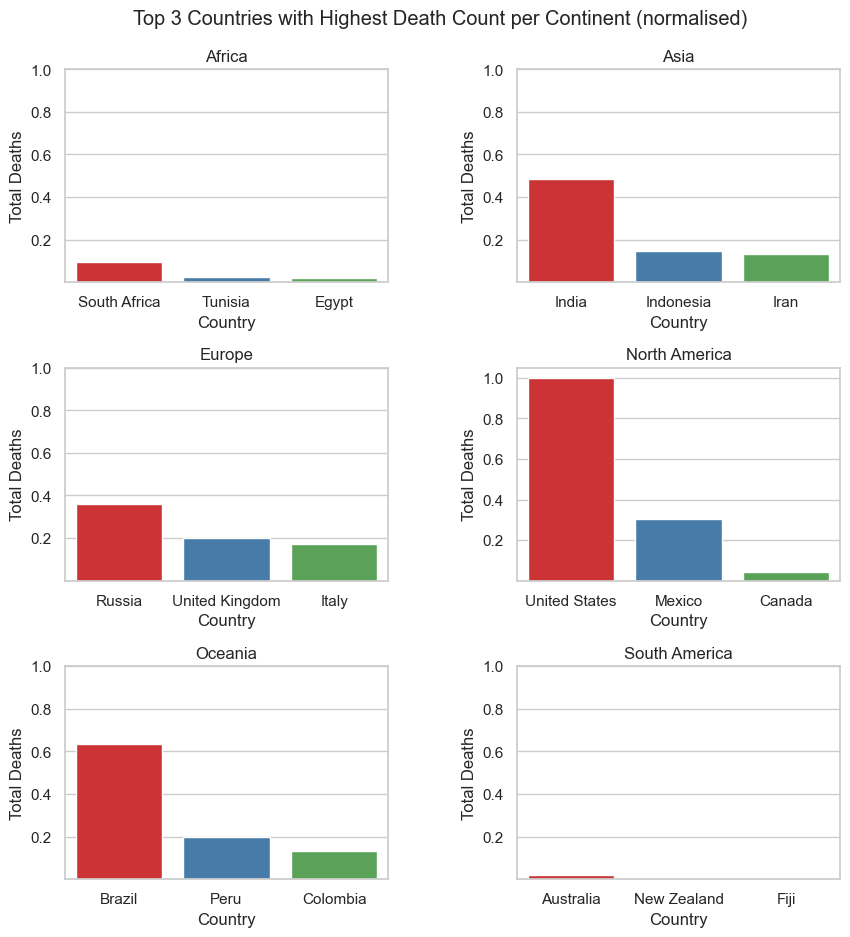

In [322]:
# Top 3 Countries w highest death count per continent NORMALISED
fig,axs = plt.subplots(3,2,figsize=(10,10))
#data5v2.max_deaths_norm = np.log10(data5v2.max_deaths_norm)
sns.barplot(data=data5v2[data5v2.continent== 'Africa'], x='location', y='max_deaths_norm', palette='Set1',ax=axs[0,0])
sns.barplot(data=data5v2[data5v2.continent== 'Asia'], x='location', y='max_deaths_norm', palette='Set1',ax=axs[0,1])
sns.barplot(data=data5v2[data5v2.continent== 'Europe'], x='location', y='max_deaths_norm', palette='Set1',ax=axs[1,0])
sns.barplot(data=data5v2[data5v2.continent== 'North America'], x='location', y='max_deaths_norm', palette='Set1',ax=axs[1,1])
sns.barplot(data=data5v2[data5v2.continent== 'South America'], x='location', y='max_deaths_norm', palette='Set1',ax=axs[2,0])
sns.barplot(data=data5v2[data5v2.continent == 'Oceania'], x='location', y='max_deaths_norm', palette='Set1',ax=axs[2,1])
plt.ticklabel_format(style='plain',axis='y')
fig.suptitle('Top 3 Countries with Highest Death Count per Continent (normalised)')
plt.subplots_adjust(wspace = 0.4,top=.92,hspace=.4)

axes = [ax for ax_lst in axs for ax in ax_lst]
for ax,continent in zip(axes,data5v2.continent.unique()):
    ax.set_title(continent)
    ax.set_ylabel('Total Deaths')
    ax.set_xlabel('Country')

axs[0,0].set_yticks([.2,.4,.6,.8,1])
axs[0,1].set_yticks([.2,.4,.6,.8,1])
axs[1,0].set_yticks([.2,.4,.6,.8,1])
axs[1,1].set_yticks([.2,.4,.6,.8,1])
axs[2,0].set_yticks([.2,.4,.6,.8,1])
axs[2,1].set_yticks([.2,.4,.6,.8,1])
#axs[2,1].set_yticks([0.01,0.025])

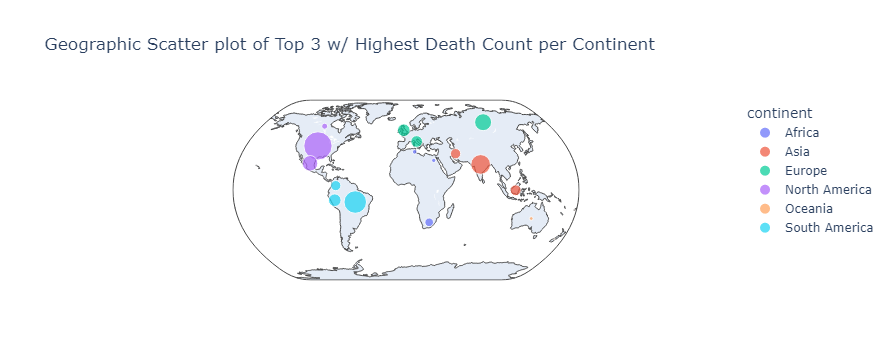

In [320]:
import plotly.express as px
px.scatter_geo(data_frame=sqldf('''
with a as (select *, rank() over (partition by continent order by max_deaths desc) as row
from (
    Select iso_code,continent,location, max(Total_deaths) as max_deaths
    From df
    Where continent is not null
    group by 1,2
    order by 1,2
    ))
select iso_code,continent,location,max_deaths, max_deaths / (select max(max_deaths) from a) as max_deaths_norm
from a where row between 1 and 3
'''), locations='isocode', color='continent', hover_name='location',
projection="natural earth",size='max_deaths',title='Geographic Scatter plot of Top 3 w/ Highest Death Count per Continent')